In [1]:
import os
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
import numpy as np
import copy 
from functools import partial
import math
import matplotlib.pyplot as plt
import imblearn.ensemble as ensemble
import sklearn.tree as tree
import sklearn.svm as svm
from sklearn.metrics import f1_score

class RegrGuessAvg:
    def __init__(self):
        self.avg = None

    def fit(self,_,y):
        self.avg = np.mean(y)
    
    def predict(self, x):
        return np.ones(x.shape[0])*self.avg
    
class RegrMetaGuessAvg:
    def __init__(self):
        self.avg = None

    def fit(self,y,meta):
        avg = {}
        for key in np.unique(meta):
            if np.sum(meta == key) > 0:
                avg[key] = np.mean(y[meta==key])
            else:
                avg[key] = np.mean(y)
        self.avg = avg

    def predict(self, meta):
        return np.asarray([self.avg[key] for key in meta])
    
class ClassificationRandomGuess:
    def __init__(self):
        self.y = None

    def fit(self,_,y):
        self.y = y
    
    def predict(self, X):
        return np.random.choice(self.y,size=X.shape[0])
    
class VoteReject:
    def __init__(self):
        pass

    def fit(self,_,__):
        pass
    
    def predict(self, x):
        return np.zeros(x.shape[0])
    
class VoteAccept:
    def __init__(self):
        pass
    
    def fit(self,_,__):
        pass
    
    def predict(self, x):
        return np.ones(x.shape[0])

In [2]:

iclr = pd.read_csv("../feature_extraction/iclr.csv")
iclr = iclr[iclr.status != "Desk Reject"]
neurips = pd.read_csv("../feature_extraction/neurips.csv")


In [12]:
def normalize(train, test):
    mean = np.mean(train,axis=0)
    std = np.std(train,axis=0)

    return (train-mean)/std,(test-mean)/std

def mse(x,y):
    return np.mean((np.asarray(x)-np.asarray(y))**2)

def acc(x,y):
    return np.mean((np.asarray(x) == np.asarray(y)).astype(np.int32))

def f1(x,y):
    x = np.asarray(x)
    if x.size == 1:
        x = np.ones_like(y)*x

    return f1_score(x,y)


def train_and_stats(model, X_train, X_test, y_train, y_test, stats_fn):
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    stats = stats_fn(y_pred,y_test)

    coefficients = []
    if hasattr(model, 'coef_'):
        coefficients = model.coef_
    
    return stats, coefficients

In [4]:
def split_dataset(df, num_splits = 5):
    len_dataset = len(df)
    df_deepcopy = copy.deepcopy(df)
    dfs = []
    for _ in range(1,num_splits+1):
        dfs.append(df_deepcopy[:int(len_dataset/num_splits)])
        df_deepcopy = df_deepcopy[int(len_dataset/num_splits):]
    
    train_test_splits = []
    for i in range(len(dfs)):
        test_split = copy.deepcopy(dfs[i])
        train_split = []
        for j in range(len(dfs)):
            if j != i:
                train_split.append(copy.deepcopy(dfs[j]))
        train_split = pd.concat(train_split)

        train_test_splits.append((train_split,test_split))
    return train_test_splits

def prepare_dataset(df_train,df_test,y_map_fn,X_map_fn,meta_map_fn):

    X_train = X_map_fn(df_train)
    y_train = y_map_fn(df_train)
    meta_train = meta_map_fn(df_train)

    X_test = X_map_fn(df_test)
    y_test = y_map_fn(df_test)
    meta_test = meta_map_fn(df_test)

    X_train,X_test = normalize(X_train, X_test)

    return X_train, X_test, y_train, y_test, meta_train, meta_test

def plot_regression(models, df ,y_map_fn, xlabel, ylabel, stats_fn, title):

    features_list = ["num_equations","mean_num_new_symbols_introduced","num_overall_unique_symbols","mean_num_unique_symbols","std_of_unique_symbols","max_representational_complexity"]
    X_map_fn = lambda df : df[features_list]
    meta_map_fn = lambda df : df.status
    
    models_and_stats = copy.deepcopy(models)
    coefficients_dict = {}
    for name,model in models_and_stats.items():
        stats_dict = {"all" : []}
        for key in np.unique(meta_map_fn(copy.deepcopy(df))):
            if not key in stats_dict:
                stats_dict[key] = []
        models_and_stats[name] = (model,stats_dict)    

    for name, (model,stats_dict) in models_and_stats.items():
        train_test_splits = split_dataset(df)
        train_test_splits = [prepare_dataset(*split,y_map_fn=y_map_fn,X_map_fn=X_map_fn,meta_map_fn=meta_map_fn) for split in train_test_splits]
        
        for X_train, X_test, y_train, y_test, meta_train, meta_test in train_test_splits:
            m = model()
            if isinstance(m,RegrMetaGuessAvg):
                m.fit(y_train,meta_train)
                y_pred = m.predict(meta_test)
            else:
                m.fit(X_train,y_train)
                y_pred = m.predict(X_test)
            stats = stats_fn(y_pred,y_test)
            stats_dict["all"].append(stats)
            for key in meta_map_fn(copy.deepcopy(df)):
                if np.sum(meta_test == key) > 0:
                    stats = stats_fn(y_pred[meta_test == key],y_test[meta_test == key])
                    stats_dict[key].append(stats)

            coefficients = []
            if hasattr(m, 'coef_'):
                coefficients = m.coef_

            if len(coefficients) == 0:
                coefficients = [0]*len(features_list)
            coefficients_dict[name] = coefficients
    
    models_and_stats = {key : {subkey : np.mean(subvalue) for subkey,subvalue in value[1].items()} for key,value in models_and_stats.items()}
    fig,axs = plt.subplots(nrows=1,ncols=len(["all",*np.unique(meta_map_fn(copy.deepcopy(df)))]))
    for meta_key,ax in zip(["all",*np.unique(meta_map_fn(copy.deepcopy(df)))],axs):
        for model_name, stats in models_and_stats.items():
            ax.bar(model_name,stats[meta_key],color = "blue")
        ax.tick_params(axis='x', labelrotation=75)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        ax.set_title(meta_key)
    fig.set_size_inches(28,6)
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()
        


    try:

        plt.figure(figsize=(12, 6))
        for name, coef in coefficients_dict.items():
            plt.plot(features_list, coef, marker='o', label=name)
        plt.xlabel('Features')
        plt.ylabel('Model Coefficients')
        plt.title('Regression Coefficients for Different Models')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()
    
    except:
        return

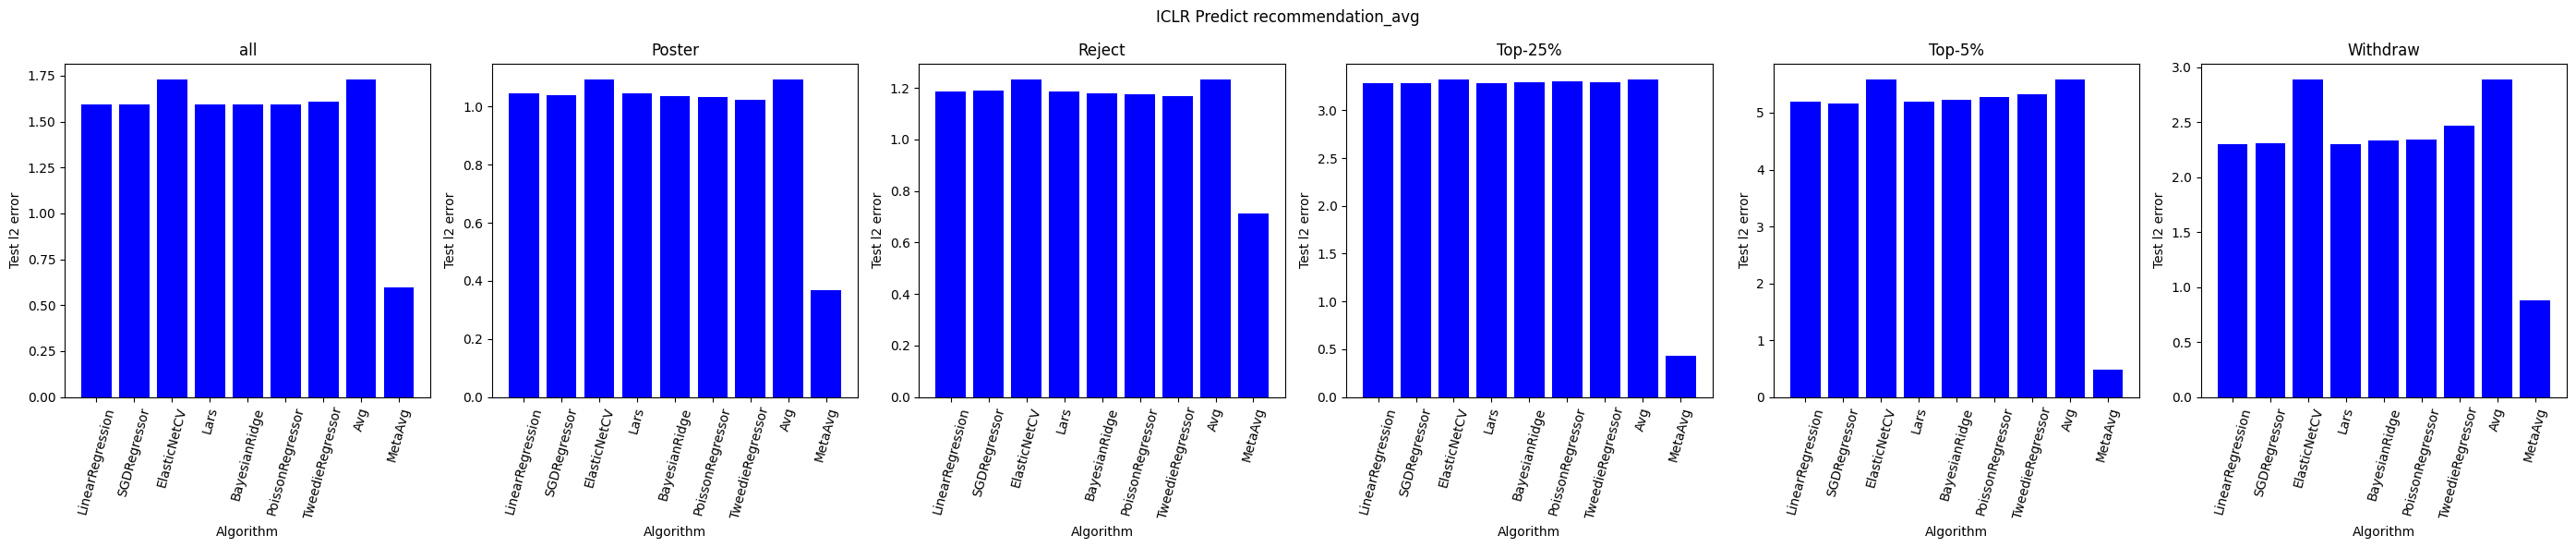

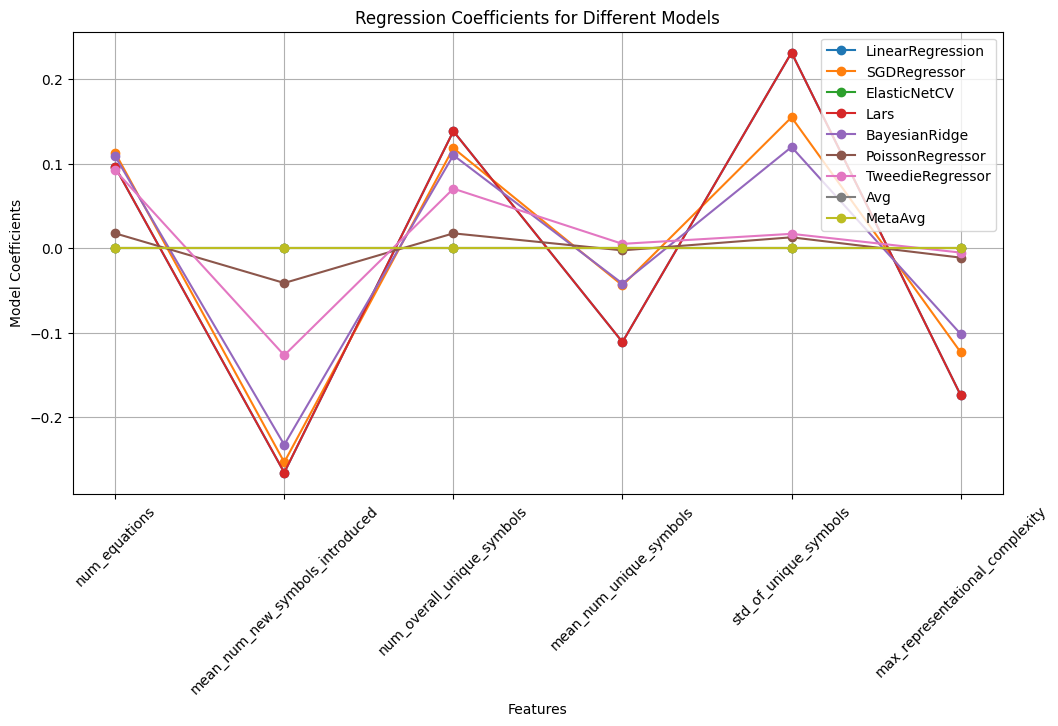

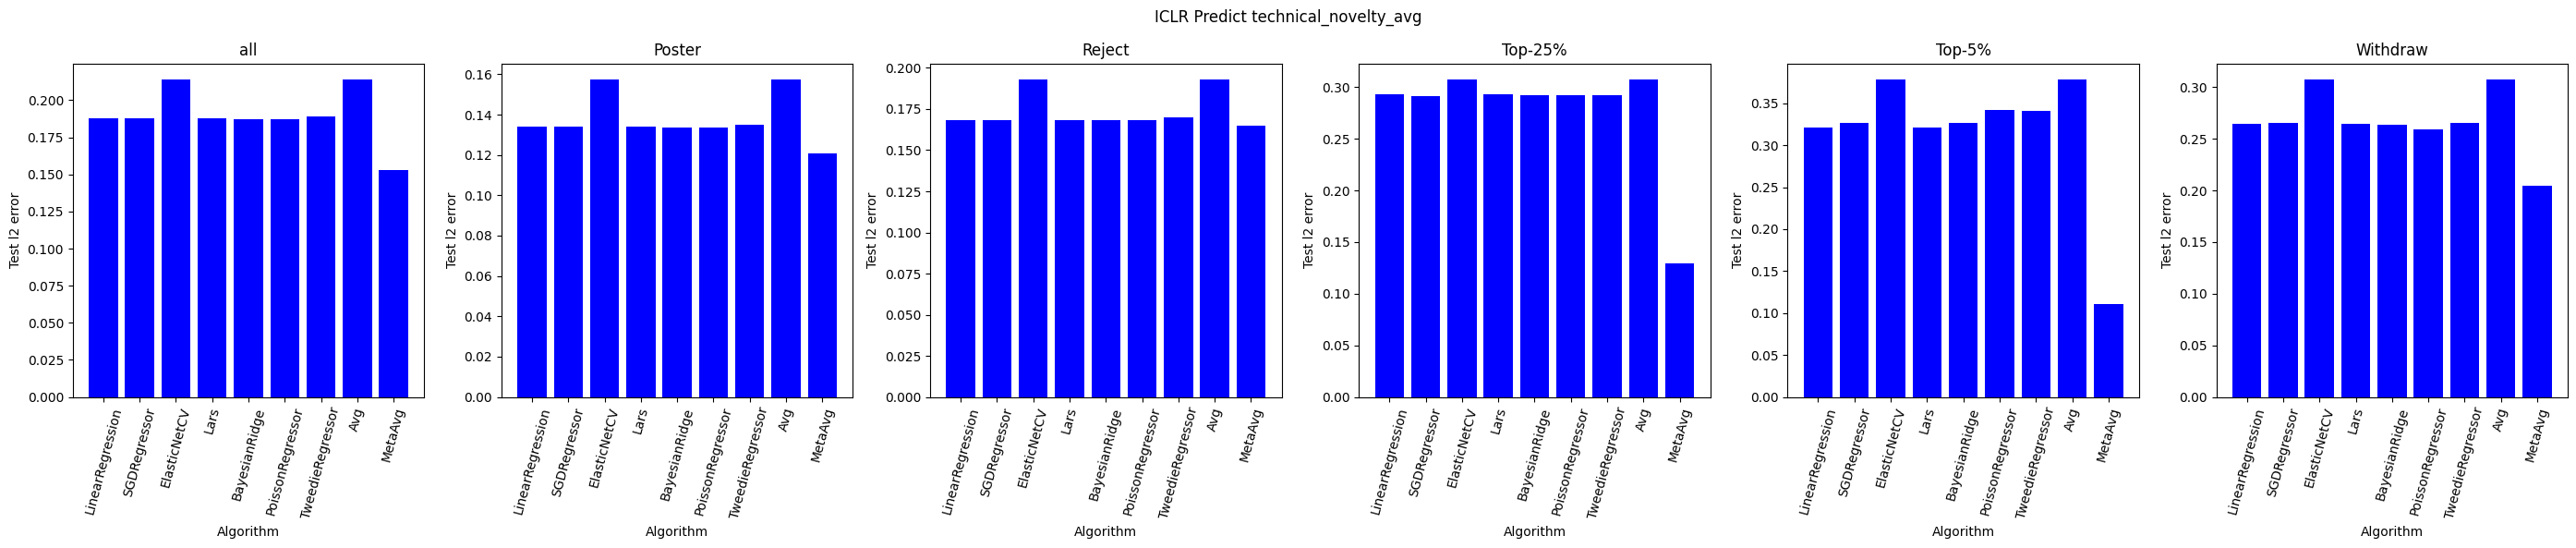

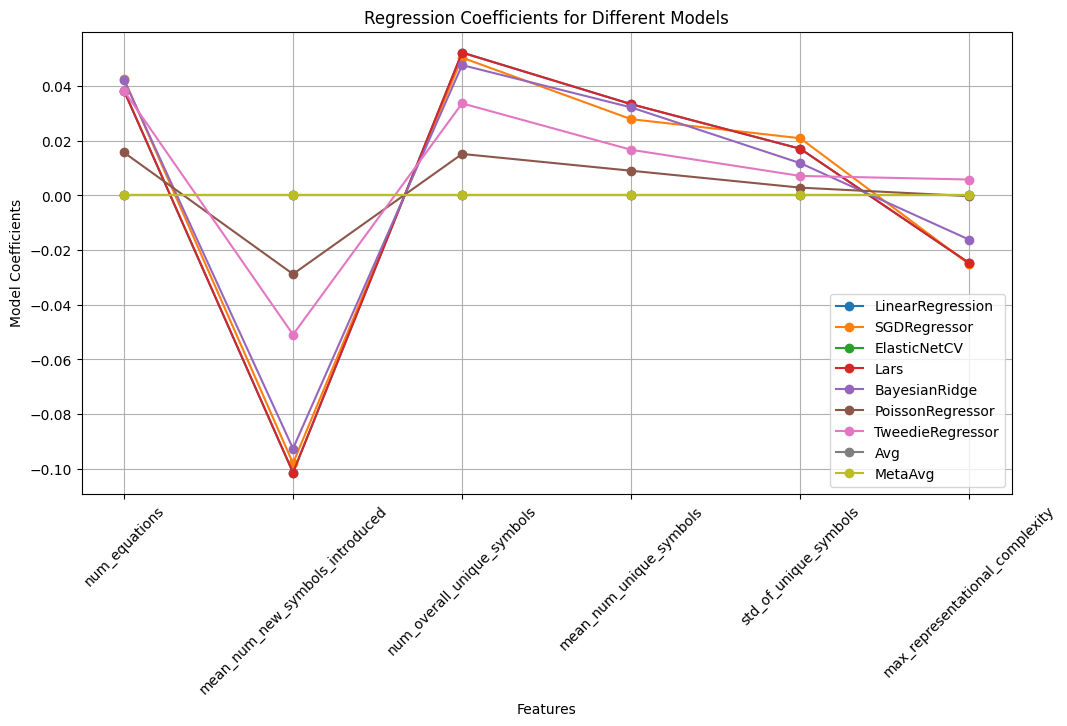

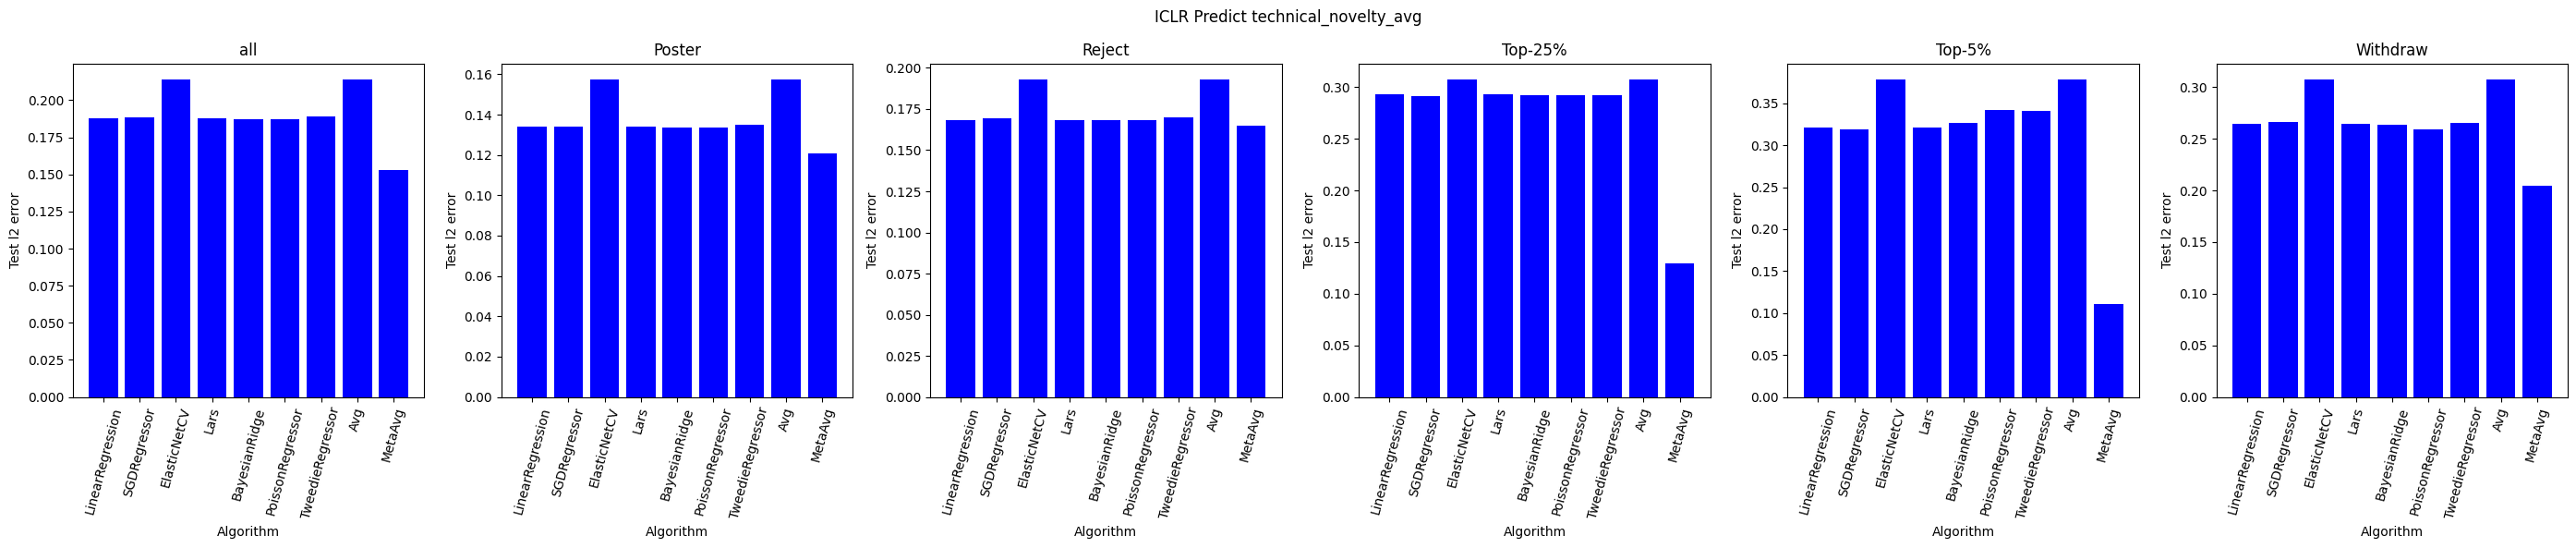

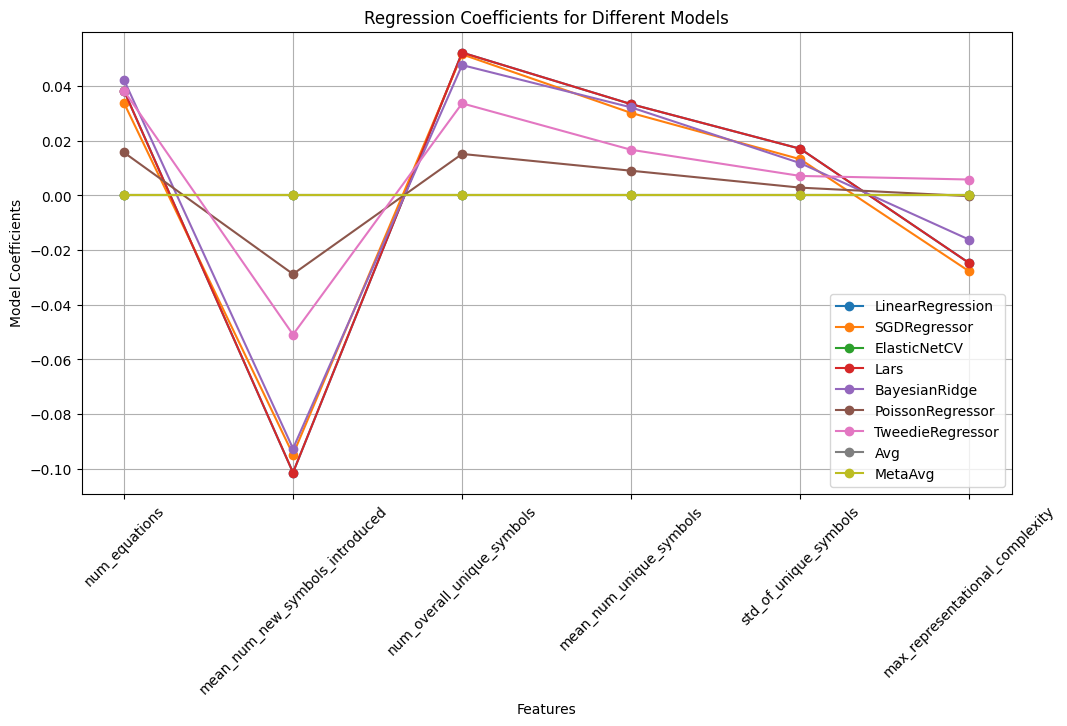

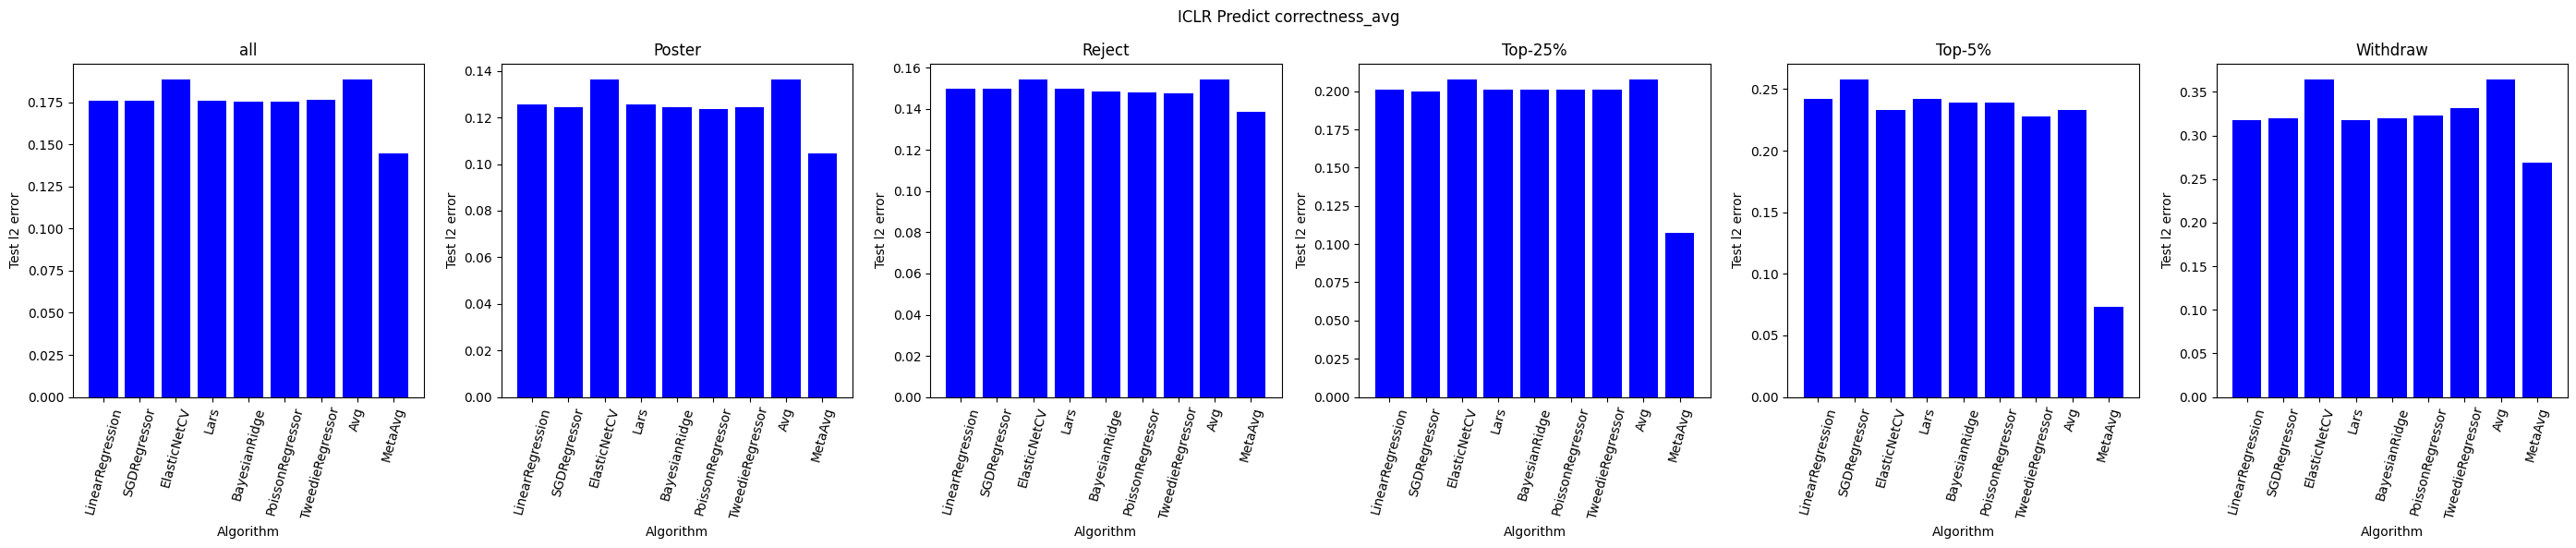

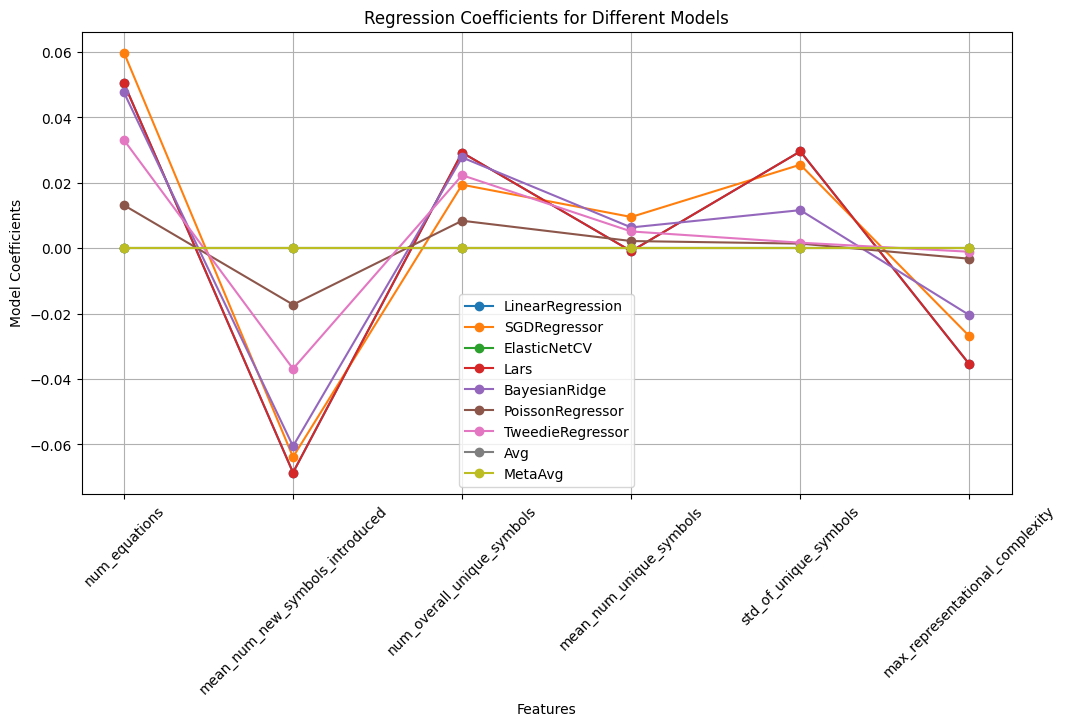

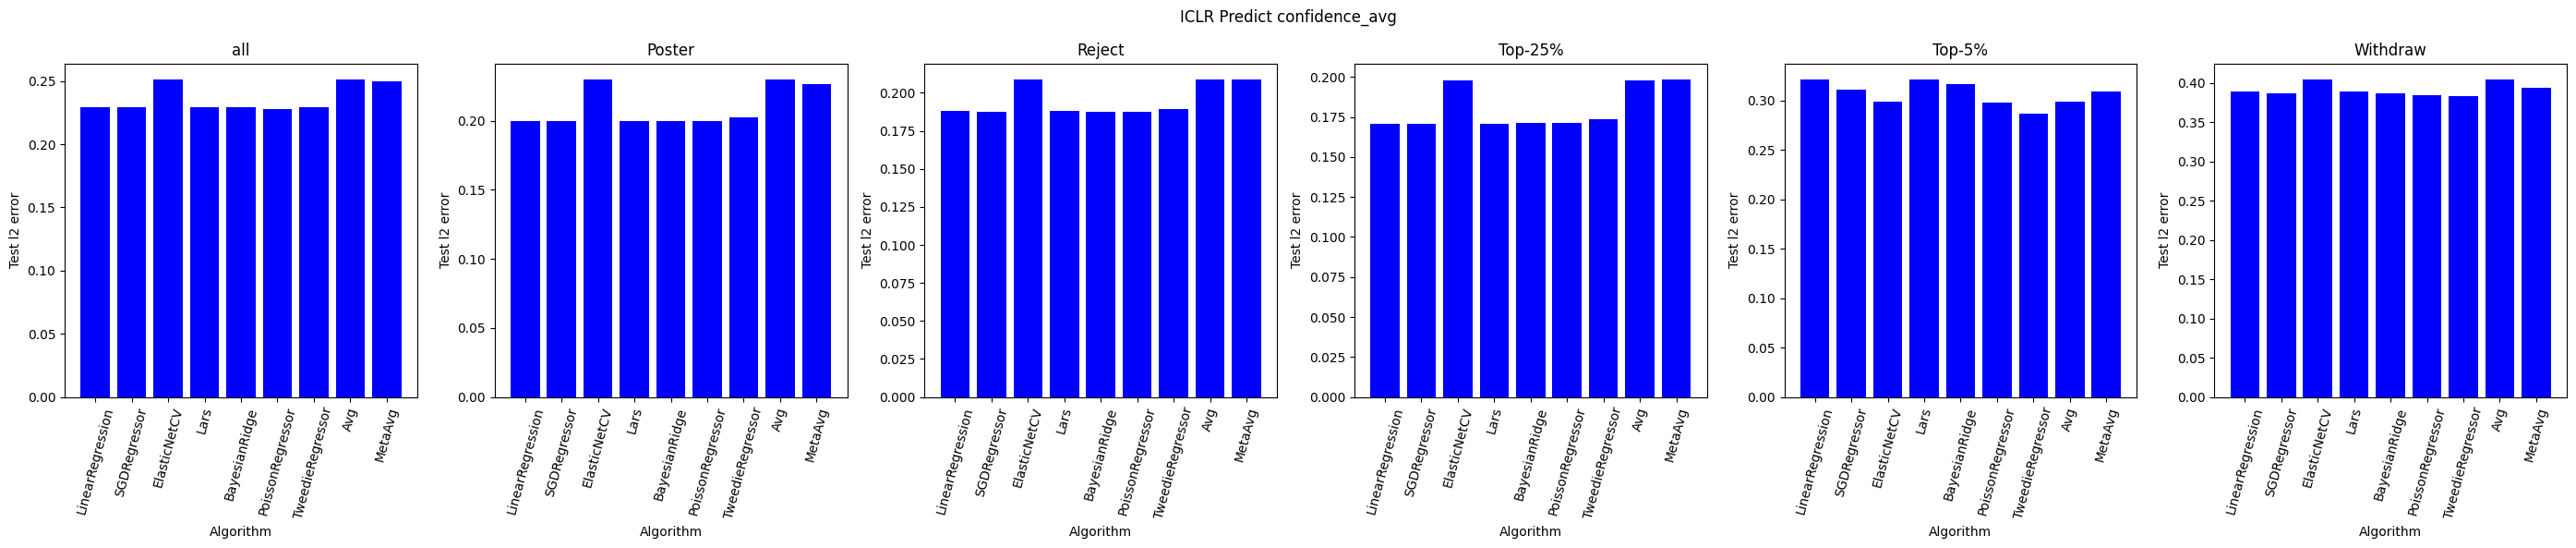

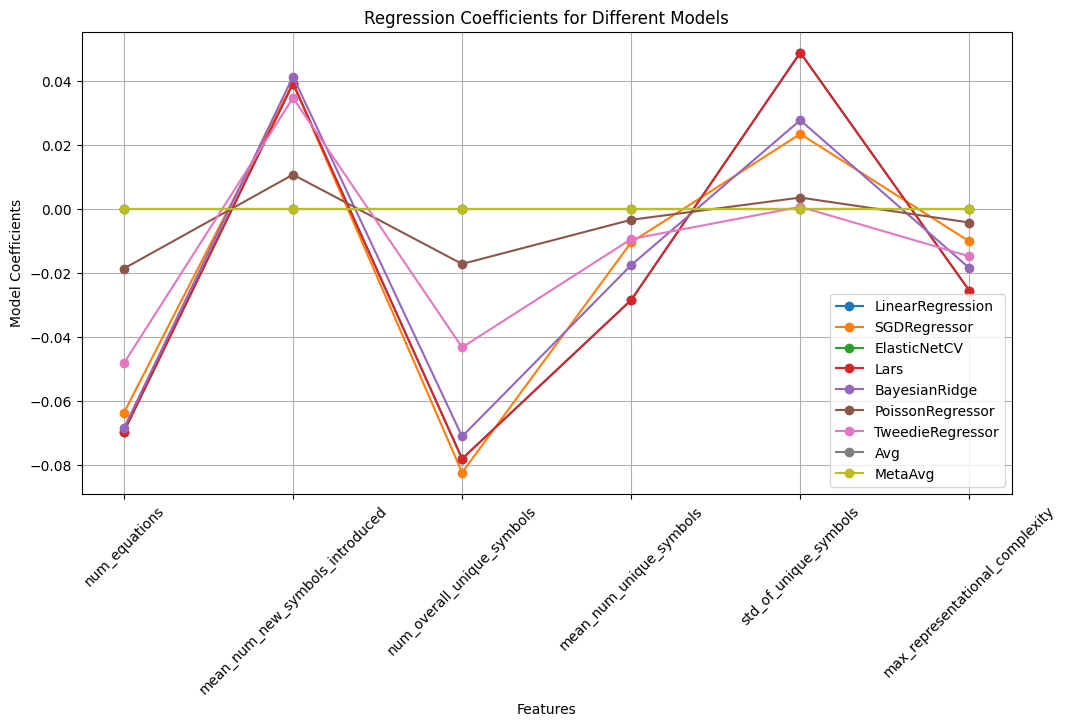

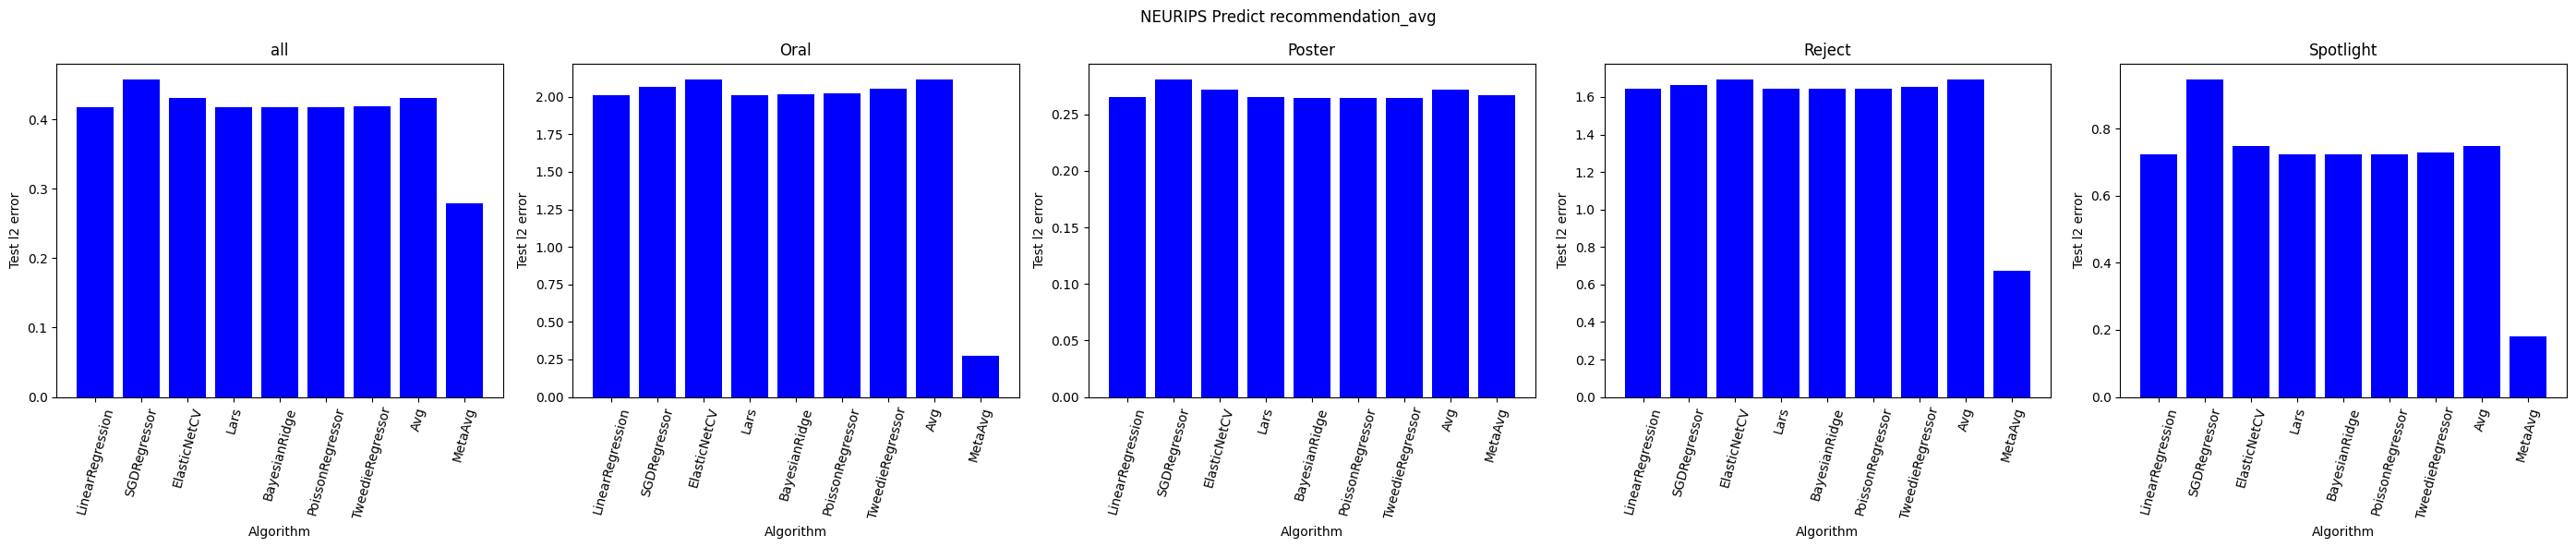

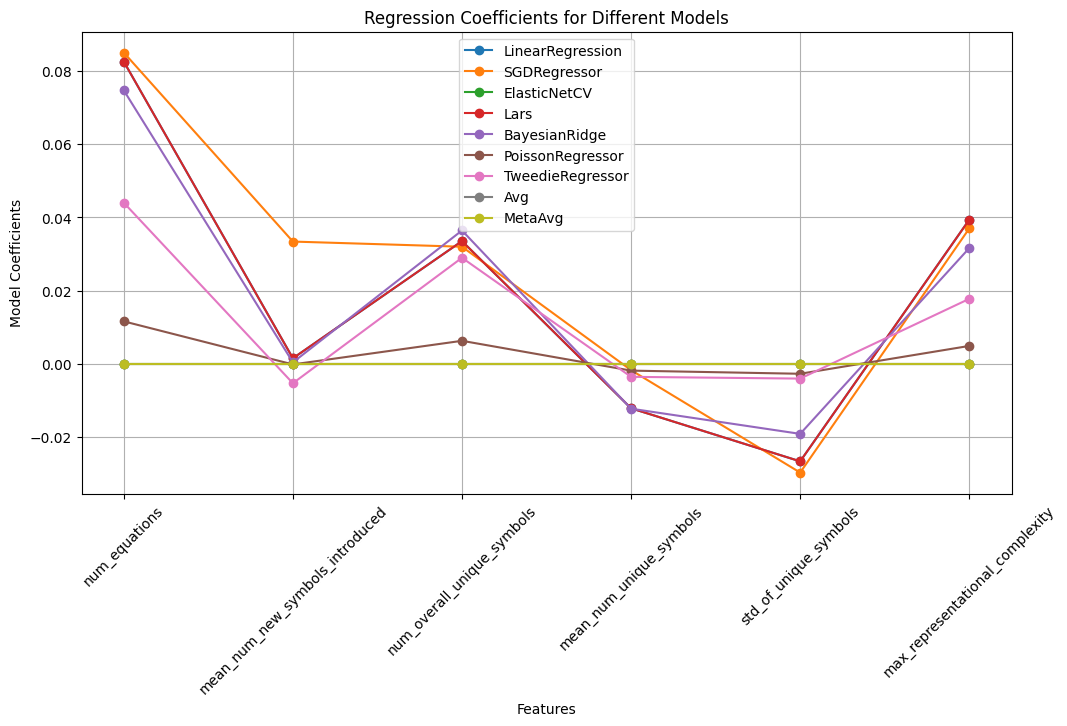

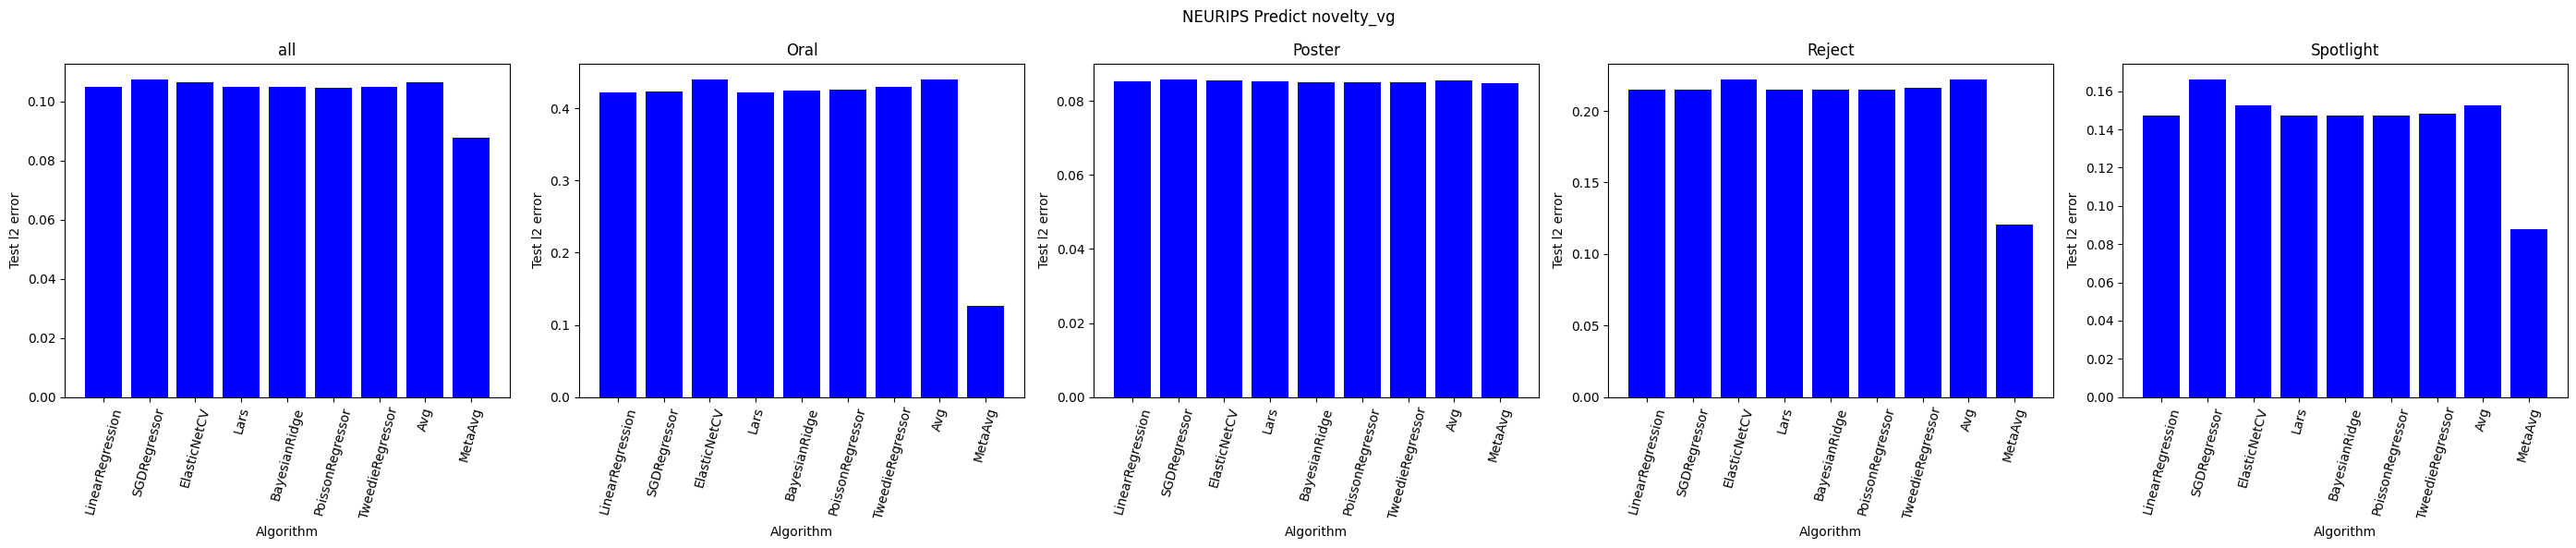

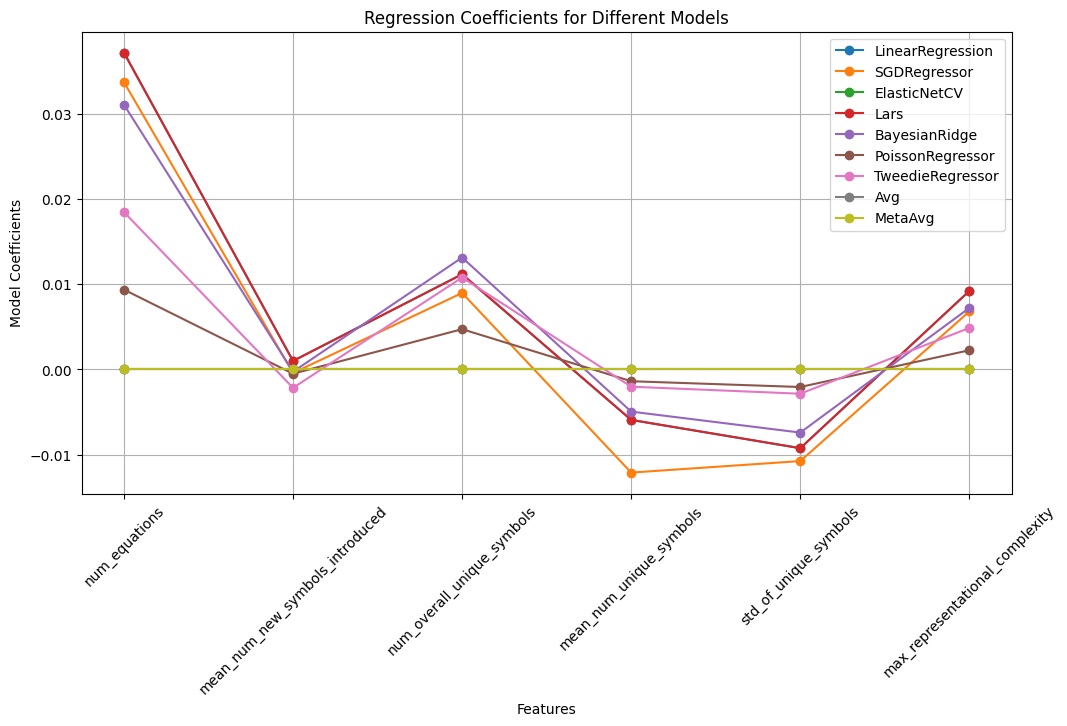

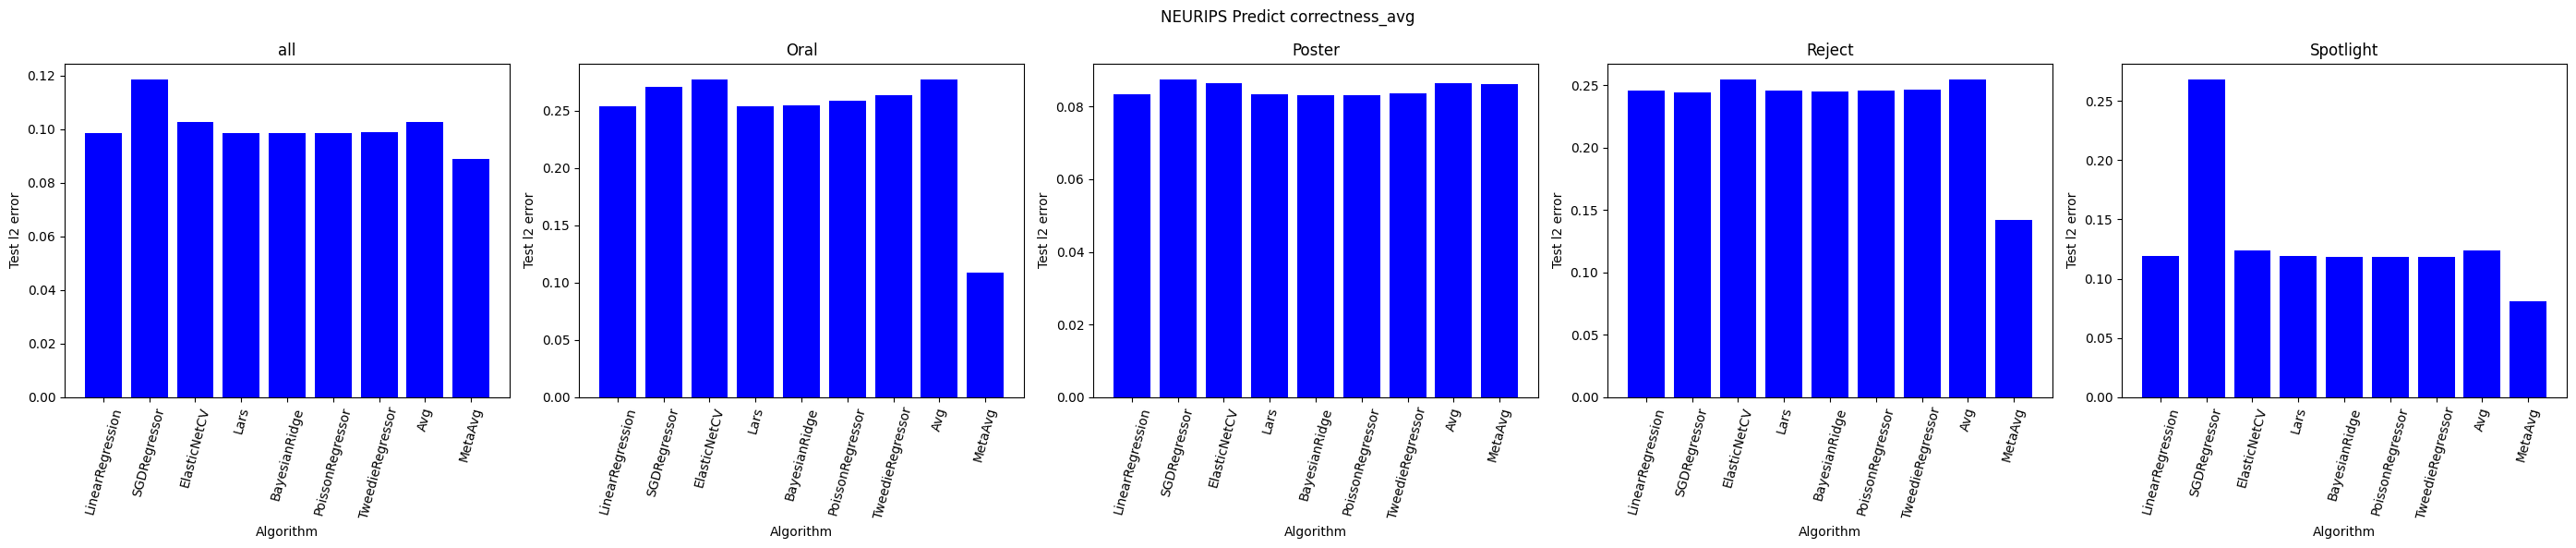

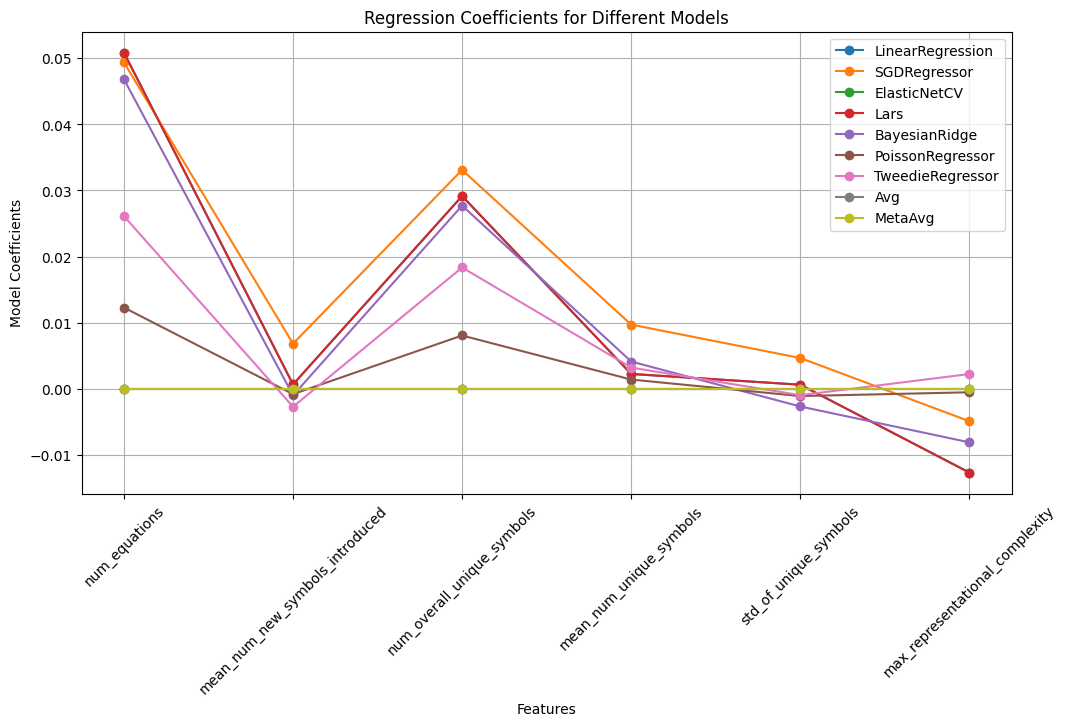

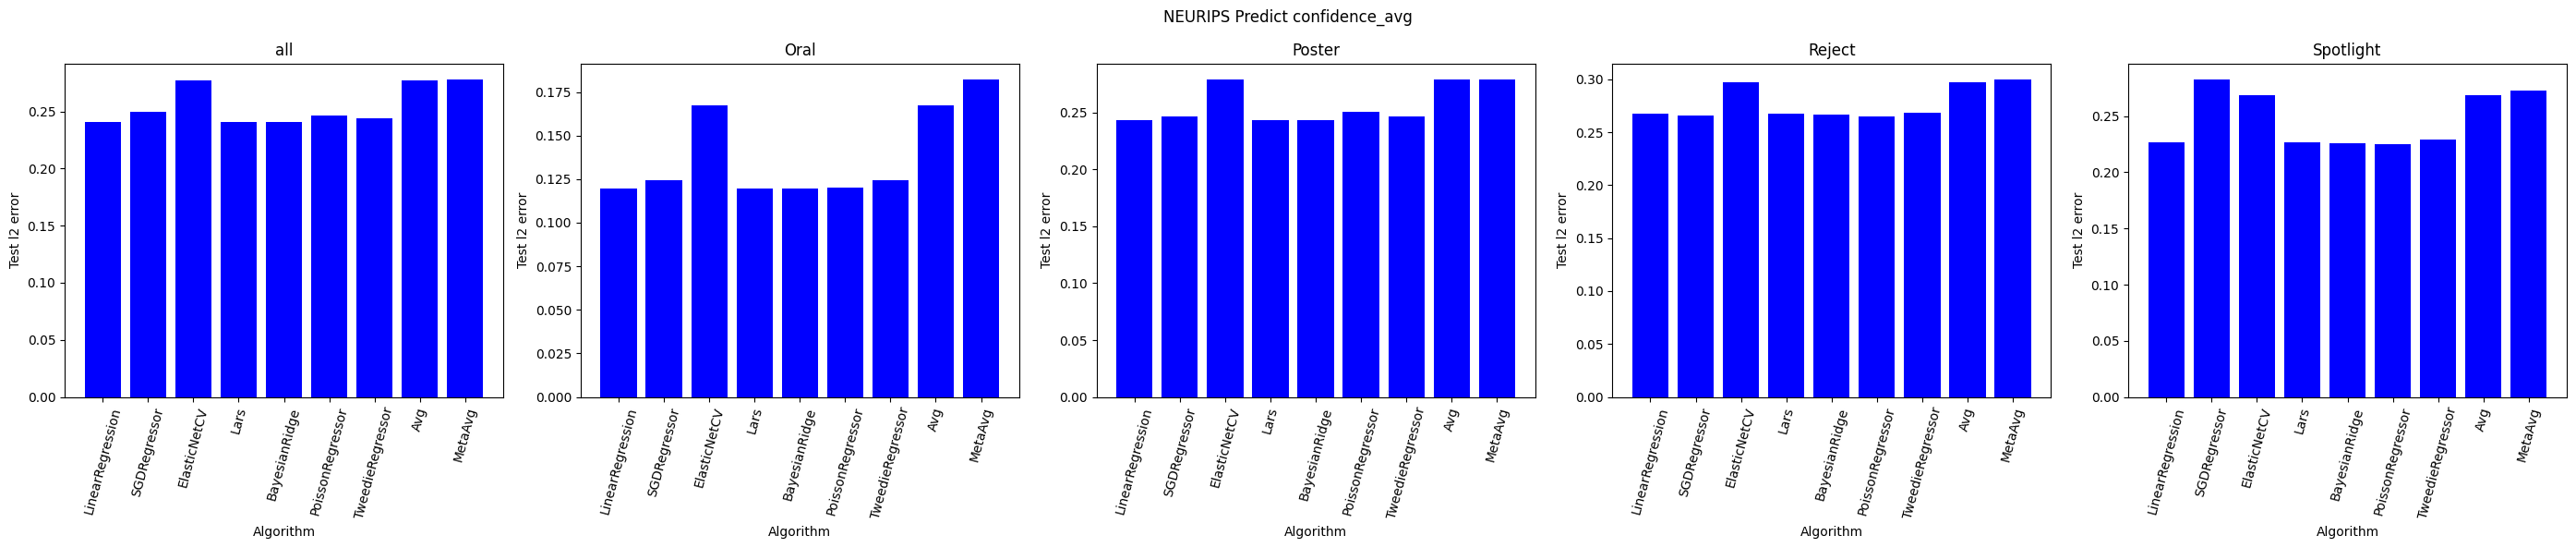

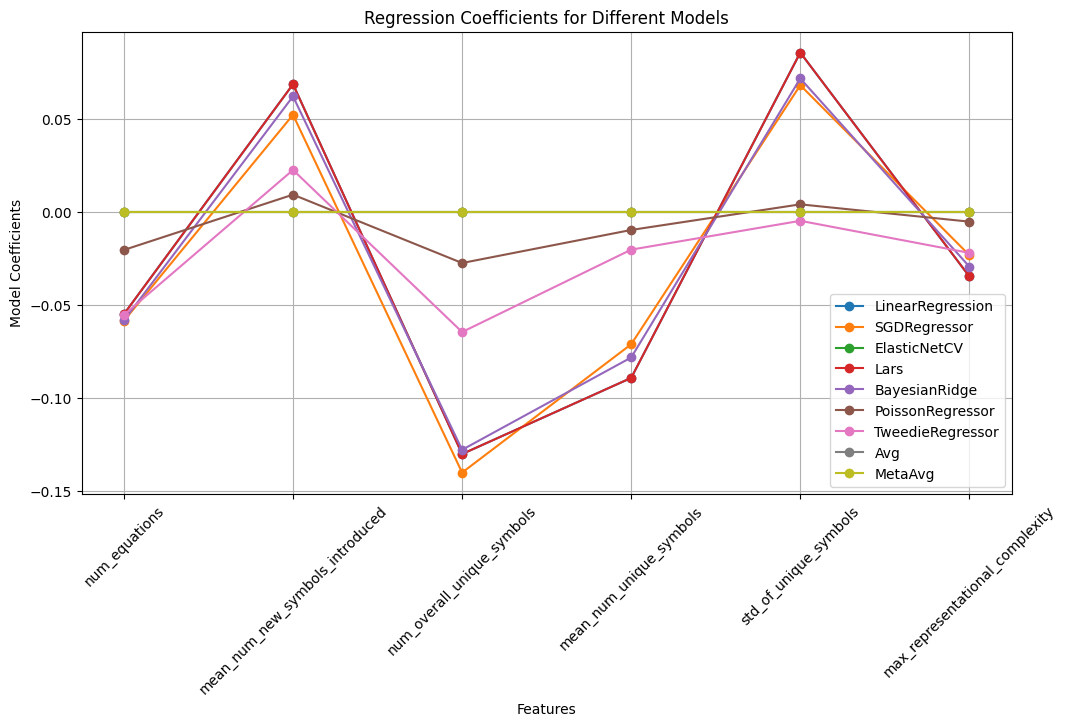

In [5]:
models = {"LinearRegression" : partial(lm.LinearRegression),
          "SGDRegressor" : partial(lm.SGDRegressor), 
          "ElasticNetCV" : partial(lm.ElasticNet), 
          "Lars" : partial(lm.Lars), 
          "BayesianRidge" : partial(lm.BayesianRidge), 
          "PoissonRegressor" : partial(lm.PoissonRegressor), 
          "TweedieRegressor" : partial(lm.TweedieRegressor), 
          "Avg" : partial(RegrGuessAvg),
          "MetaAvg" : partial(RegrMetaGuessAvg)}


plot_regression(models,iclr,y_map_fn=lambda df : np.asarray(df.recommendation_avg),xlabel="Algorithm",stats_fn=mse,ylabel = "Test l2 error",title="ICLR Predict recommendation_avg")
plot_regression(models,iclr,y_map_fn=lambda df : np.asarray(df.technical_novelty_avg),xlabel="Algorithm",stats_fn=mse,ylabel = "Test l2 error",title="ICLR Predict technical_novelty_avg")
plot_regression(models,iclr,y_map_fn=lambda df : np.asarray(df.technical_novelty_avg),xlabel="Algorithm",stats_fn=mse,ylabel = "Test l2 error",title="ICLR Predict technical_novelty_avg")
plot_regression(models,iclr,y_map_fn=lambda df : np.asarray(df.correctness_avg),xlabel="Algorithm",stats_fn=mse,ylabel = "Test l2 error",title="ICLR Predict correctness_avg")
plot_regression(models,iclr,y_map_fn=lambda df : np.asarray(df.confidence_avg),xlabel="Algorithm",stats_fn=mse,ylabel = "Test l2 error",title="ICLR Predict confidence_avg")

plot_regression(models,neurips,y_map_fn=lambda df : np.asarray(df.recommendation_avg),xlabel="Algorithm",stats_fn=mse,ylabel = "Test l2 error",title="NEURIPS Predict recommendation_avg")
plot_regression(models,neurips,y_map_fn=lambda df : np.asarray(df.novelty_avg),xlabel="Algorithm",stats_fn=mse,ylabel = "Test l2 error",title="NEURIPS Predict novelty_vg")
plot_regression(models,neurips,y_map_fn=lambda df : np.asarray(df.correctness_avg),xlabel="Algorithm",stats_fn=mse,ylabel = "Test l2 error",title="NEURIPS Predict correctness_avg")
plot_regression(models,neurips,y_map_fn=lambda df : np.asarray(df.confidence_avg),xlabel="Algorithm",stats_fn=mse,ylabel = "Test l2 error",title="NEURIPS Predict confidence_avg")

In [6]:
def iclr_x_mapfn(df):
    return df[df.status != "Withdraw"][["num_equations","mean_num_new_symbols_introduced","num_overall_unique_symbols","mean_num_unique_symbols","std_of_unique_symbols","max_representational_complexity"]]
def iclr_y_mapfn(df):

    y = df[df.status != "Withdraw"].status
    y = np.asarray(y)
    y[y == "Reject"] = 0
    y[y == "Desk Reject"] = 0
    y[y == "Top-25%"] = 1
    y[y == "Top-5%"] = 1
    y[y == "Poster"] = 1

    
    return y.astype(np.int32)

def neurips_y_mapfn(df):
    y = df.status
    y = np.asarray(y)
    y[y == "Reject"] = 0
    y[y == "Poster"] = 1
    y[y == "Spotlight"] = 1
    y[y == "Oral"] = 1

    return y.astype(np.int32)


In [13]:

def plot_classification(models, df ,y_map_fn, xlabel, ylabel, stats_fn, title, X_map_fn = lambda df : df[["num_equations","mean_num_new_symbols_introduced","num_overall_unique_symbols","mean_num_unique_symbols","std_of_unique_symbols","max_representational_complexity"]],
         sort_reverse=False):

    features_list = ["num_equations","mean_num_new_symbols_introduced","num_overall_unique_symbols","mean_num_unique_symbols","std_of_unique_symbols","max_representational_complexity"]
    models_and_stats = copy.deepcopy(models)
    coefficients_dict = {}
    for name,model in models_and_stats.items():
        models_and_stats[name] = (model,[])    

    for name, (model,stats_list) in models_and_stats.items():
        train_test_splits = split_dataset(df)
        train_test_splits = [prepare_dataset(*split,y_map_fn=y_map_fn,X_map_fn=X_map_fn,meta_map_fn=lambda x : None) for split in train_test_splits]
        
        for X_train, X_test, y_train, y_test, _ , _ in train_test_splits:
            stats, coefficients = train_and_stats(model(),X_train, X_test, y_train, y_test, stats_fn)
            stats_list.append(stats)
            if len(coefficients) == 0:
                coefficients = [0]*len(features_list)
            coefficients_dict[name] = coefficients
   
    models_and_stats = {key: value for key, value in sorted(models_and_stats.items(), reverse=sort_reverse,key=lambda e: np.mean(e[1][1]))}

    for name,(model,stats_list) in models_and_stats.items():
        plt.bar(name,np.mean(stats_list),color = "blue")

    ax = plt.gca()
    ax.tick_params(axis='x', labelrotation=75)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    plt.show()

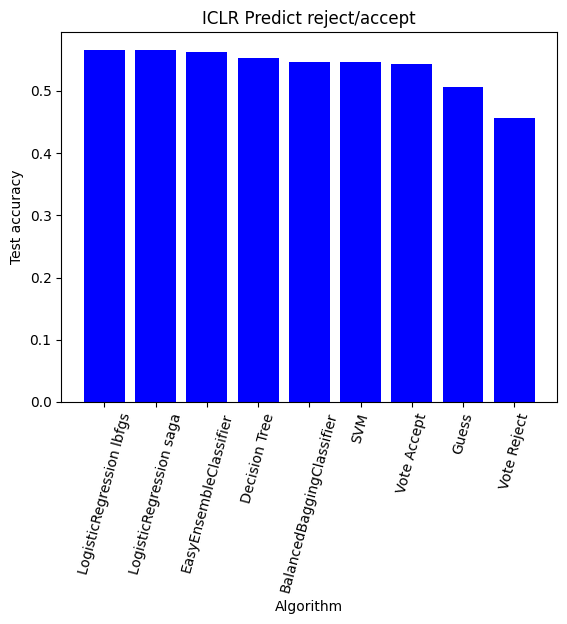

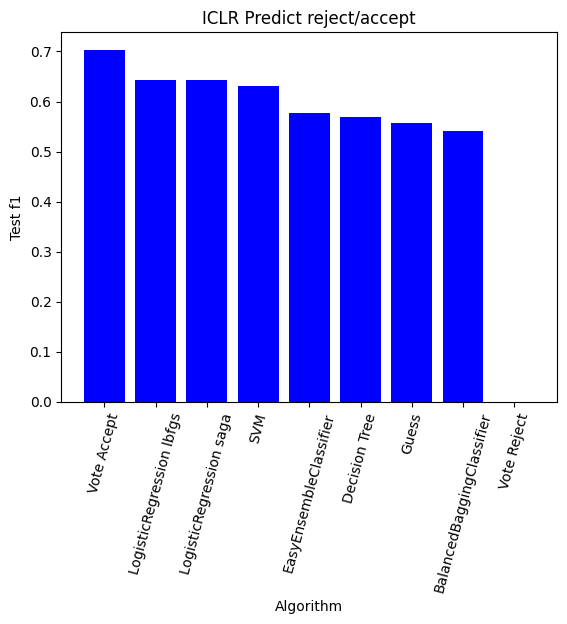

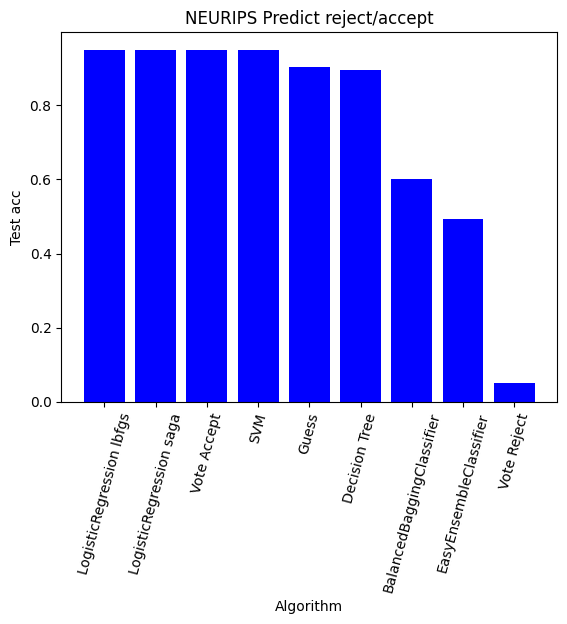

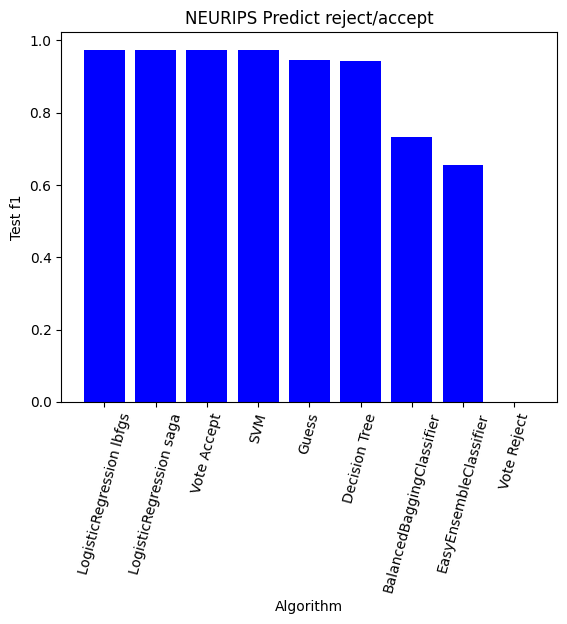

In [14]:
models = {"LogisticRegression lbfgs" : partial(lm.LogisticRegression,max_iter=50000,solver="lbfgs"),
          "LogisticRegression saga" : partial(lm.LogisticRegression,max_iter=50000,solver="saga"),
          "Guess" : partial(ClassificationRandomGuess), 
          "Vote Reject" : partial(VoteReject), 
          "Vote Accept" : partial(VoteAccept), 
          "Decision Tree" : partial(tree.DecisionTreeClassifier),
          "SVM" : partial(svm.SVC),
          "BalancedBaggingClassifier" : partial(ensemble.BalancedBaggingClassifier),
          "EasyEnsembleClassifier" : partial(ensemble.EasyEnsembleClassifier),
}

plot_classification(models,iclr,y_map_fn=iclr_y_mapfn,X_map_fn=iclr_x_mapfn,xlabel="Algorithm",ylabel = "Test accuracy",stats_fn=acc,title="ICLR Predict reject/accept",sort_reverse=True)
plot_classification(models,iclr,y_map_fn=iclr_y_mapfn,X_map_fn=iclr_x_mapfn,xlabel="Algorithm",ylabel = "Test f1",stats_fn=f1,title="ICLR Predict reject/accept",sort_reverse=True)
plot_classification(models,neurips,y_map_fn=neurips_y_mapfn,xlabel="Algorithm",ylabel = "Test acc",stats_fn=acc,title="NEURIPS Predict reject/accept",sort_reverse=True)
plot_classification(models,neurips,y_map_fn=neurips_y_mapfn,xlabel="Algorithm",ylabel = "Test f1",stats_fn=f1,title="NEURIPS Predict reject/accept",sort_reverse=True)